# 本文件说明
- 读取数据、预处理数据

# 基本设置

In [10]:
import xlrd

%matplotlib inline
import numpy as np
import pandas as pd
from toolkits.nlp import pre_cor_circ
from toolkits.nlp import pre_cor_cbrc
from toolkits.setup.specific_func import contain_ch, set_ch_pd
set_ch_pd()
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## 一些函数

In [11]:
def predict_right(folder, file_list):
    '''预测正确数据'''
    right_data = pd.DataFrame()
    for file_name in file_list:
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:    
            tmp_data = pd.read_excel(currentPath, sheet_name)
    #         tmp_data = tmp_data[tmp_data['R_W'] == 'Right']
            print('去空值前： ', tmp_data.shape, file_name, sheet_name)
#             tmp_data = tmp_data[tmp_data['备注'] != '删除']
    #         tmp_data = tmp_data.dropna(subset = ['raw_title'], axis = 0)
#             print('去空值后： ', tmp_data.shape, file_name, sheet_name)
            right_data = pd.concat([right_data, tmp_data], axis = 0)    
    return right_data

In [12]:
def correct_wrong_data(folder, file_list):
    '''预测错误修正后数据'''
    correct_wrong_data = pd.DataFrame()
    for file_name in file_list:
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:    
            tmp_data = pd.read_excel(currentPath, sheet_name)
    #         tmp_data = tmp_data[tmp_data['R_W'] == 'Wrong']
            print('去删除前： ', tmp_data.shape, file_name, sheet_name)
            tmp_data = tmp_data[tmp_data['备注'] != '删除']
    #         tmp_data = tmp_data.dropna(subset = ['raw_title'], axis = 0)
            print('去删除后： ', tmp_data.shape, file_name, sheet_name)

            tmp_data['人工判断'] = tmp_data.apply(lambda x:1 if x['label'] == x['备注'] else 0, axis = 1)
            tmp_data['算法判断'] = tmp_data.apply(lambda x:1 if x['predict_label'] == x['备注'] else 0, axis = 1)
            print('人工误判率： %0.2f'%(1 - tmp_data['人工判断'].sum() / tmp_data.shape[0]),
                  '算法误判率： %0.2f'%(1 - tmp_data['算法判断'].sum() / tmp_data.shape[0]))
            print()

            correct_wrong_data = pd.concat([correct_wrong_data, tmp_data], axis = 0)
    return correct_wrong_data

In [13]:
def get_new_data(folder, file_list):
    '''新补充数据'''
    new_data = pd.DataFrame()
    for file_name in file_list:
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:    
            tmp_data = pd.read_excel(currentPath, sheet_name)
            print(tmp_data.columns)
            tmp_data = tmp_data[['label', 'title', 'content']]
            print('去空值前： ', tmp_data.shape, file_name, sheet_name)
            tmp_data = tmp_data.dropna(subset = ['label'], axis = 0)
            print('去空值后： ', tmp_data.shape, file_name, sheet_name)
            new_data = pd.concat([new_data, tmp_data], axis = 0)    
    return new_data

In [14]:
def get_PR_plot_data(feedback_data, date, plot_data):
    y_pred_class = feedback_data[feedback_data['date'] == date]['predict_label'].tolist()
    y_test = feedback_data[feedback_data['date'] == date]['label'].tolist()
    print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
    print(metrics.classification_report(y_test, y_pred_class))
    print('confusion_matrix: ')
    print( metrics.confusion_matrix(y_test, y_pred_class))
    print()       
    
    classification_report = metrics.classification_report(y_test, y_pred_class)
    lines = classification_report.split('\n')
    # plot_data = []
    for index, line in enumerate(lines[2 : len(lines)]):
        t = line.strip().split()
        if len(t) < 2: continue    
        if (index + 2) < (len(lines) - 2):
            t = [float(v) if i > 0 else v for i, v in enumerate(t)]
            plot_data.append(t + [date])
        else :
            t = [float(v) if i > 2 else v for i, v in enumerate(t) ]
            plot_data.append(['avg/total'] + t[3:] + [date])    
            
    return plot_data

In [15]:
def get_feedback_data(folder, file_list):
    '''模型预测后反馈数据'''
    feedback_data = pd.DataFrame()
    label_list = []
    sum_list = []
    right_list = []
    plot_data = []
    for file_name in file_list:
        print('  ----    ', file_name)
        date = file_name.split('_')[0]
        currentPath  = '{0}/{1}'.format(folder, file_name)
        excel = xlrd.open_workbook(currentPath)
        sheet_names = [sheet.name for sheet in excel.sheets()]
        for sheet_name in sheet_names:   
            tmp_data = pd.read_excel(currentPath, sheet_name)    
            tmp_data = tmp_data[tmp_data['label'] != '删除']
            tmp_data_1 = tmp_data[tmp_data['label'] == sheet_name]

            label_list.append(sheet_name)
            sum_list.append(tmp_data.shape[0])
            right_list.append(tmp_data_1.shape[0])
            print('类别：', sheet_name, '总数：', tmp_data.shape[0], 
                  '正确数', tmp_data_1.shape[0], 
                  '正确比例', tmp_data_1.shape[0]/tmp_data.shape[0])
            
            if 'predict_label' in tmp_data_1.columns:
                tmp_data_1 = tmp_data[['predict_label', 'label', 'title', 'content']]
            else :
                tmp_data_1 = tmp_data[['label', 'title', 'content']]
                if contain_ch(sheet_name) :
                    tmp_data_1['predict_label'] = sheet_name
                else :
                    tmp_data_1['predict_label'] = ''
                
            tmp_data_1['date'] = date
            print('去空值前： ', tmp_data_1.shape, file_name, sheet_name)
            tmp_data_1 = tmp_data_1.dropna(subset = ['label'], axis = 0)
            print('去空值后： ', tmp_data_1.shape, file_name, sheet_name)
            feedback_data = pd.concat([feedback_data, tmp_data_1], axis = 0)
            print() 
                        
        plot_data = get_PR_plot_data(feedback_data, date, plot_data) 
            
    PR_data = feedback_data[['date', 'predict_label', 'label']]
    feedback_data = feedback_data.drop('date', axis = 1)
    feedback_data = feedback_data.drop('predict_label', axis = 1)
    PR_plot_data  = pd.DataFrame(plot_data, columns = ['label', 'precision', 'recall', 
                                                    'f1-score', 'support', 'date'])     
    
    return feedback_data, PR_data, PR_plot_data

In [16]:
def pre_save(pre_func, data, save_folder):
    print(data.shape)
    print('save_folder: ', save_folder)
    
    titles = pre_func(data['title'].tolist())
    print('title num: ', len(titles))
    save_filename = save_folder + 'corpus/titles.txt'
    fid = open(save_filename, "w+", encoding='UTF-8')
    for line in titles:
        fid.write(line + '\n')
    fid.close()  
    
#     print(len(data['content'].tolist()))
    contents = pre_func(data['content'].tolist())
    print('content num: ', len(contents))
    print(contents[0])
    # contents = [re.sub(r'[a-z]*', '', x) for x in contents]
    # print(len(contents))
    # print(contents[:2])
    coprus_save_filename = save_folder + 'corpus/contents.txt'
    f = open(coprus_save_filename, "w+", encoding='UTF-8')
    for line in contents:
        f.write(line + '\n')
    f.close()    

    label = data['label'].tolist()
    print('label num: ', len(label))
    coprus_save_filename = save_folder + 'corpus/labels.txt'
    f = open(coprus_save_filename, "w+", encoding='UTF-8')
    for line in label:
        f.write(str(line) + '\n')
    f.close()

    data.to_excel(save_folder + 'corpus/title_content_label.xlsx', index = False)
    

# 保险业：1 八分类

## 读取数据

In [17]:
folder = 'circ_data_class/20180910'

### 预测正确数据

In [18]:
file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
circ_raw_class_1 = predict_right(folder, file_list_1)

circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
circ_raw_class_1.columns = ['label', 'title', 'content']
print('总数：', circ_raw_class_1.shape)
circ_raw_class_1.head()

去空值前：  (1284, 8) circ_class_sel_else_20180827.xlsx 公司内部管理
去空值前：  (3197, 8) circ_class_sel_else_20180827.xlsx 噪音
去空值前：  (1320, 8) circ_class_sel_else_20180827.xlsx 行业
去空值前：  (1463, 8) circ_class_sel_else_20180827.xlsx 消费服务
去空值前：  (753, 8) circ_class_sel_else_20180827.xlsx 资本市场
去空值前：  (1511, 8) circ_class_sel_else_20180827.xlsx 监管
去空值前：  (500, 8) circ_class_sel_else_20180827.xlsx 产品销售
去空值前：  (1403, 8) circ_class_sel_else_20180827.xlsx 其他相关报道
总数： (11431, 3)


,label,title,content
0,公司内部管理,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定书之日起60 日内依法向中国保监会申请行政复议，...
1,公司内部管理,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减100元”的克扣标准，将该助理原本每月3500元的底薪，克扣到1200元。而这些克扣标准，张龙此前从未告知过刘丽和其他新来的助理。由此，刘丽认为自己遭遇了招聘“骗局”。\n\r 随后，其他新来的助理也知道了薪资标准被故意隐瞒的情况，...
2,公司内部管理,上海人寿整改应对监管 万能险收紧后仍过保费半数,上海人寿屡被监管关照 万能险收紧后仍占半壁江山\n\r(图片)\n\r投资时报\n\r01月09日\n\r13:43\n\r关注\n\r确定不再关注此人吗\n\r确定\n\r取消\n\r屡被“关照”上海人寿应对整改 万能险收紧后仍过保费半数 | 保险监管风云录\n\r文 | 标点财经研究员 黄凤清\n\r成立未满三年的上海人寿，已屡次成为监管层的关照对象。继2016年因万能险问题成为被中国保监会要求整改的9家保险公司之一后，2017年第四季度，上海人寿又一次接到保监会的监管函。\n\r《投资时报》在对2017年保监会出具的37张监管函进行统计和回顾，并推出《保险监管风云录》专题报道时注意到，上海人寿的案例颇值得研究。\n\r10月11日，保监会公布了针对上海人寿保险股份有限公司的监管函，指出于2017年3月9日至4月15日对该公司进行了公司治理现场评估，查实该公司在“三会一层”运作、关联交易、内部审计、考核激励等方面存在问题。具体来看有六大违规问题，在公司治理运作方面，包括董事会运作不规范、独立董事制度缺失及管理不规范、高级管理人员免职未按时报备；在内部管控方面，包括关联交易管理不规范、薪酬管理不合规、内部审计管理不到位。\n\r针对上述问题，保监会提出了具体的监管要求，包括要求上海人寿在接到监管函后立即实施整改工作，成立由主要负责人牵头的专项工作组，制定切实可行的整改方案；按照整改方案对评估发现的问题逐项整改，形成整改报告，并于2017年11月30日前书面报至保监会；自监管函下发之日起六个月内禁止该公司直接或间接与览海控股（集团）有限公司及其关联方开展下列交易：提供借款或其他形式的财务资助、除存量关联交易的终止行为（如到期、赎回、转让等）以外开展资金运用类关联交易（包括现有金融产品的续期，以及已经签署协议但未实际支付的交易），上述六个月期满之日起三个月为观察期，观察期内保监会将对此项监管措施的落实情况进行检查，视情况采取后续监管措施等。\n\r其中，览海控股（集团）有限公司为上海人寿的第一大股东，至2017年三季度末持股比例为20%。\n\r对于保监会此次下发的监管函，上海人寿对《投资时报》表示，公司已在第一时间成立了以董事长为组长、总裁和董事会秘书为副组长的公司治理整改专项小组，研究制定具体的整改措施，部分问题已经完成整改，如进一步完善了面向董事的信...
3,公司内部管理,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度\n\r0\n\r缩小文字\n\r放大文字\n\r2018-01-12\n\r来源：\n上海证券报\n·\n要闻\n\r “侨兴债”事件继续发酵，浙商财险9位高管被问责\n\r 保监会加大“双罚制”执行力度\n\r ⊙记者 陈婷婷 ○编辑 陈羽\n\r “侨兴债”风险事件在保险业继续发酵。除了此前的行业警示之外，昨日，保监会又向卷入“侨兴债”风险事件的浙商财险开出罚单，曝出该公司五大问题，涉及业务、人员聘任、内控管理等多个方面。而被罚款202万元、停止接受保证保险新业务1年的处罚对浙商财险乃至保险全行业都敲响了警钟。\n\r 机构受处罚，相关责任人也不能逃脱干系。罚单对相关负责人进行责任追溯，浙商财险9位高管被问责，时任总经理被撤职。事实上，从去年开始，保监会及各地保监局频频下发的行政处罚就告别了重机构轻高管的处罚惯例。11日，一同下发的另外三张罚单便是针对三家险企的总精算师。未来，对主要责任人与机构“双罚”将成常态。\n\r 罚单直指浙商财险内控漏洞\n\r 上证报记者此前统计，去年全国各地保险监管机构下发行政处罚决定书超过850张，创下近年来保险业罚单新纪录。\n\r 新年伊始，监管的处罚力度丝毫没有减弱。昨日，保监会再次开出新年首批四张罚单，分别针对浙商财险、农银人寿、长城人寿和交银康联人寿。\n\r 其中，浙商财险因涉及侨兴债，被罚202万元、信用保证保险业务被停一年而受市场关注。保监会介绍，2014年浙商财险承保两笔保证保险业务，保额均为5.73亿元。根据浙商财险2014年度资产负债表，单一风险单位即每笔私募债占比超过《保险法》规定实有资本金加公积金总和的10%。同时，浙商财险未按照规定使用经批准或者备案的保险条款、保险费率未按规定提取准备金，也是在承保侨兴债过程中暴露出的风险治理漏洞。\n\r 保监会近日在行业内部下发《浙商财险侨兴私募债保证保险业务风险事件分析及启示》

In [19]:
circ_raw_class_1['label'].value_counts()

噪音        3197
监管        1511
消费服务      1463
其他相关报道    1403
行业        1320
公司内部管理    1284
资本市场       753
产品销售       500
Name: label, dtype: int64

### 预测错误修正后数据

In [20]:
file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
circ_raw_class_2.columns = ['label', 'title', 'content']
print('总数：', circ_raw_class_2.shape)
circ_raw_class_2.head()

去删除前：  (394, 8) circ_class_sel_20180827-1.xlsx 公司内部管理
去删除后：  (390, 8) circ_class_sel_20180827-1.xlsx 公司内部管理
人工误判率： 0.27 算法误判率： 0.47

去删除前：  (193, 8) circ_class_sel_20180827-1.xlsx 资本市场
去删除后：  (190, 8) circ_class_sel_20180827-1.xlsx 资本市场
人工误判率： 0.24 算法误判率： 0.48

去删除前：  (405, 8) circ_class_sel_20180827-1.xlsx 行业
去删除后：  (397, 8) circ_class_sel_20180827-1.xlsx 行业
人工误判率： 0.27 算法误判率： 0.53

去删除前：  (385, 8) circ_class_sel_20180827-1.xlsx 监管
去删除后：  (381, 8) circ_class_sel_20180827-1.xlsx 监管
人工误判率： 0.12 算法误判率： 0.75

去删除前：  (230, 8) circ_class_sel_20180827-2.xlsx 消费服务
去删除后：  (228, 8) circ_class_sel_20180827-2.xlsx 消费服务
人工误判率： 0.12 算法误判率： 0.71

去删除前：  (486, 8) circ_class_sel_20180827-2.xlsx 噪音
去删除后：  (469, 8) circ_class_sel_20180827-2.xlsx 噪音
人工误判率： 0.18 算法误判率： 0.65

去删除前：  (188, 8) circ_class_sel_20180827-2.xlsx 其他相关报道
去删除后：  (184, 8) circ_class_sel_20180827-2.xlsx 其他相关报道
人工误判率： 0.14 算法误判率： 0.65

去删除前：  (144, 8) circ_class_sel_20180827-2.xlsx 产品销售
去删除后：  (141, 8) circ_class_sel_20180827-2.xlsx 产品

,label,title,content
0,公司内部管理,太平人寿2016年原保费收入接近千亿大关,"太平人寿2016年原保费收入接近千亿大关\n\r(图片) \n财经头条 1年前\n\r记者19日获悉，持续践行中国太平集团“精品”发展战略的太平人寿，在2016年依然保持了稳健的发展态势。太平人寿2016年原保险保费收入直逼千亿大关，达到943.64亿元，较2015年同期增长18.1%。总体来说，太平人寿2016年全面超额完成各项业务指标，更实现了规模、价值的双增长，新业务价值保持稳步增长。\n\r#该摘要由财秘智能技术提供\n\r记者19日获悉，持续践行中国太平集团“精品”发展战略的太平人寿，在2016年依然保持了稳健的发展态势。太平人寿2016年原保险保费收入直逼千亿大关，达到943.64亿元，较2015年同期增长18.1%。\n\r 总体来说，太平人寿2016年全面超额完成各项业务指标，更实现了规模、价值的双增长，新业务价值保持稳步增长。\n\r 更难得的是，在保费规模不断扩大的同时，太平人寿业务品质始终保持行业领先地位，个险、银保13月继续率、25月继续率均超过90%，四项继续率指标之和超过380%，凸显出太平人寿业务的健康、稳健和后劲足。\n\r猜你喜欢\n\r太平人寿上半年原保险保费收入突破800亿元\n\r(图片)\n\r2017年原保险保费收入36581亿\n\r(图片)\n\r综合征税还有很长的路要走\n\r(图片)\n\r京东4.83亿参股安联财险 互联网+保险再迎风口\n\r(图片)\n\r当重疾来敲门，有人选择用银行卡余额治病，有人选择用保单保额，结果可大不同\n\r(图片)\n\r京东保险棋局落下重要一子 入股安联财险跻身二股东\n\r(图片)\n\r京东终于拿下保险牌照 4.83亿入股安联\n\r(图片)\n\r京东4.83亿元入股安联财险拿下保险牌照 持股30%\n\r(图片)\n\r-已经到底了-\n""}}"
1,公司内部管理,经过一年半时间的筹建 首家科技保险公司正式开业,"现在是科技时代，在我们日常生活中，处处都离不开现代科技，比如快捷付款之类。但最近保险科技最近成了一个热词，并且科技改变保险的同时，保险对科技的专项服务也拉开了序幕。1月9日，经保监会同意，经过一年半左右时间的筹建，中国太平保险集团旗下太平科技保险公司正式开业，这也是国内首家专业的科技保险公司。\n""}}"
2,公司内部管理,安心财险“闲时退费”产品违反车险条款,近日，中国保监会对安心财险发布的监管函显示，安心财险“闲时退费”产品被定性为违反车险条款规定，同时要求安心财险对公司高管管理和车险业务进行全面自查，排查违规问题和风险隐患，加强内部管控，严格制度执行，依法开展经营，杜绝类似问题再次发生。 “闲时退费”也就是说“按天买车险”，产品创意借鉴于国外的UBI车险（驾驶行为模式基础保险）。据悉，“闲时退费”产品由安心财险承保，第三方互联网保险平台车车车险联合设计运营，其核心内容可概括为开一天车交一天车险，车主在不用车的时候，比如出差、限号、送修等场景，可以在手机客户端操作退还保费。 对此，有市场分析认为，由于UBI车险的核心在于数据收集，而国内车联网技术尚不够成熟，数据收集设备（如OBD设备）的普及以及数据的传输方式均没有得到较好的解决，因此在没有实现物联网的情况下，要真正实现 闲时退费 的可能性不大。 值得注意的是，“按天买车险”产品模式并不只有安心财险一家在做，此前市面上也有一些车险产品是按照车辆实际使用天数及里程数收取保费，不过目前已经下线。事实上，早在今年三月份，中国保险行业协会针对该类型车险模式就下发过风险提示，提醒广大车险消费者在购买保险时，提高风险意识，保护自身合法权益。 （见习编辑：陈蓉蓉） 值得注意的是，“按天买车险”产品模式并不只有安心财险一家在做，此前市面上也有一些车险产品是按照车辆实际使用天数及里程数收取保费，不过目前已经下线。事实上，早在今年三月份，中国保险行业协会针对该类型车险模式就下发过风险提示，提醒广大车险消费者在购买保险时，提高风险意识，保护自身合法权益。 （见习编辑：陈蓉蓉）
3,公司内部管理,上海人寿保险被保监会出具监管函 指其六方面违规,原标题：上海人寿保险被保监会出具监管函 指其六方面违规 千龙网北京10月11日讯 10月11日晚间，中国保监会发布监管函〔2017〕32号文件，指出上海人寿保险股份有限公司在“三会一层”运作、关联交易、内部审计、考核激励等方面存在问题。 资料图。 文件指出，2017年3月9日至4月15日，保监会对上海人寿保险股份有限公司进行了公司治理现场评估，发现上海人寿保险存在董事会运作不规范、独立董事制度缺失，管理不规范、高级管理人员免职未按时报备、关联交易管理不规范、薪酬管理不合规、内部审计管理不到位等六方面问题。 上述问题分别违反了《保险公司董事会运作指引》第二十五条、第三十条、第三十九条、第四十二条、第五十三条、第六十二条、第七十四条、第七十七条和《保险机构内部审计工作规范》第十六条规定、《关于规范保险公司治理结构的指导意见（试行）》相关规定、《保险公司独立董事管理暂行办法》第三十条以及《保险公司董事会运作指引》第二十一条规定、《保险公司董事、监事和高级管理人员任职资格管理规定》第三十三条规定、《保险公司关联交易管理暂行办法》第十三条规定、《保险公司关联交易管理暂行办法》第二十二条等有关规定、《保险公司薪酬管理规范指引（试行）》第十二条、第十三条规定、《保险公司董事及高级管理人员审计管理办法》第二条、第九条规定。 保监会对上海人寿保险股份有限公司提出四项监管要求。第一，应当高度重视公司治理评估发现的问题，在接到本监管函后立即实施整改工作，成立由主要负责人牵头的专项工作组，制定切实可行的整改方案。整改方案应当明确具体时间和措施，确保将每一项问题的整改工作落实到具体部门和责任人。 第二、应当依据相关法律法规、监管规定和公司内控制度的有关要求，按照整改方案，对评估发现的问题逐项整改，形成整改报告，并于2017年11月30日前书面报至我会。已经整改完成的，列明整改完成时间及具体措施；尚未完成的，列明整改时限及具体方案。 第三、自本监管函下发之日起六个月内，禁止上海人寿保险直接或间接与览海控股（集团）有限公司及其关联方开展下列交易：1.提供借款或其他形式的财务资助；2.除存量关联交易的终止行为（如到期、赎回、转让等）以外，开展资金运用类关联交易（包括现有金融产品的续期，以及已经签署协议但未实际支付的交易）。上述六个月期满之日起三个月为观察期。观察期内，保...
4,公司内部管理,中国太平2018年一季度保费收入624.7亿元,4月13日，中国太平保险控股(股份代码：HK00966)公布2018年一季度保费收入。中国太平控股附属太平人寿、太平财险及太平养老首季累计保费收入总计共624.6592亿元人民币(下同)。其中，太平人寿、太平财险、太平养老2018年一季度累计保费收入分别为546.0831亿元、61.4433亿元及17.1328亿元。(太平人寿)


In [21]:
circ_raw_class_2['label'].value_counts()

行业        491
公司内部管理    465
噪音        427
监管        254
产品销售      221
资本市场      215
其他相关报道    180
消费服务      127
Name: label, dtype: int64

### 新补充数据

In [22]:
file_list_3 = ['20180827_circ_class_1.xlsx'
               ] # 多个 sheet

circ_raw_class_3 = get_new_data(folder, file_list_3)

circ_raw_class_3['label'] = circ_raw_class_3['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_3.shape)
circ_raw_class_3.head()

Index(['title', 'content', 'label'], dtype='object')
去空值前：  (319, 3) 20180827_circ_class_1.xlsx 社会医疗保险
去空值后：  (319, 3) 20180827_circ_class_1.xlsx 社会医疗保险
总数： (319, 3)


,label,title,content
0,噪音,为什么医疗保险每年在加费用呢？相等的报销会增加吗？,为什么医疗保险每年在加费用呢？相等的报销会增加吗？ 待解决 匿名 问题与我的不同！ 我要立即提问 尊敬的用户请先登录后解答该咨询。 登录 | 注册 找法网认证系统 温馨提示：只有认证通过的律师才能回复咨询。 确定 律师回答 共 1 条 王文元 律师 13329126339 免费咨询 由国家的医疗保险政策确定。 律所：安徽宪达律师事务所 回复时间：2017-10-03 15:49 0 检举 评论(0) 医疗保险 更多交通事故问题>> 医疗:保险 交通事故相关词条： 交通费用能用定额发票报吗交通费赔偿标准是什么如何计算交通事故的交通费赔偿 遇到医疗保险问题您可以尝试： 1 根据您遇到的问题找一个专业律师 车祸赔偿取保候审交通事故赔偿酒驾醉驾交通肇事侵权赔偿刑事附带民事人身损害赔偿财产损害赔偿工伤索赔 2 根据您遇到的问题看相关法律知识 医疗保险概述医保报销范围社会医疗保险商业医疗保险农村医疗保险城镇职工医保 法律咨询 不用注册，快速回复，马上在线咨询专业律师！ * 标题 0/50 * 详细 您的问题描述越详细，律师回答越及时越准确~ 0/2000 地区： 请选择 请选择 请选择 分类： 未分类 悬赏5 悬赏5 悬赏10 悬赏15 悬赏20 服务： 律师回复后短信通知我（需绑定手机） 绑定手机号 律师回复后我们将第一时间发送短信通知您！ 获取验证码 确定 可以使用此号码登录找法网及找回密码 请输入以下的验证码继续提交 确定
1,噪音,临沂人注意了！有人看病多花好几万！只因不知道医疗保险的这一方面！,原标题:临沂人注意了！有人看病多花好几万！只因不知道医疗保险的这一方面！ 古语说得好 没什么别没钱，有什么别有病，即使你有医保卡。 近日，一位网友遇到了一件怪事： 自己交了这么多年的医保， 怎么忽然就不能用了？ 还听说停缴3个月余额会清零？ 原来，这位网友已从原单位辞职一个月， 这一个月并没有缴纳当月社保， 才会发生这样的情况。 但是，关于停缴3个月余额清零一说， 就纯属无稽之谈了！ 那么关于社保停缴， 都会对我们的生活造成哪些影响呢？ 且听小编为你细细梳理。 1 医保账户 社保医保由单位和个人共同缴纳。 个人缴纳月工资总额的2%，进入个人账户，用于买药、门诊、小额医疗费用的支付； 单位交5% 7%，进入社会统筹账户，用于住院花费的报销。 医保停缴的次月起，社保卡内的金额会被封存，但依然属于个人所有，不过不能直接划卡使用，就是说，钱还在，只是不能花，也不能支取。 但是以下三种情况下，个人账户里的钱可以支取使用 社保卡使用终止：如参保人死亡，亲属可凭死亡证明等办理支取手续。 参保人移民：凭公安部门出具的证明等办理支取手续。 异地转移：在当地参保后，可把医保账户余额转移至新账户。 2 停缴医保，影响连续缴费年限 医疗保险自停缴之日起有3个月缓冲期。 如果只是3个月内中断医保缴费，那么在继续缴费的时候还可以算连续参保时间；但是如果超过了3个月，那么连续缴费年限就会清零，续缴时从零开始计算连续缴费年限。 也就是说，网友遇到的清零，是连续缴费年限，而不是余额。 3 连续缴费年限，影响重大方面 第一 影响大病门诊待遇 享受大病门诊待遇的小伙伴，在治病中产生的基本医疗费用和地方补充医疗费用，都是可以报销的，不过报销比例跟连续参保的时间有关。 举个例子： 某人生病时费用花了20000元。 原来参加了36个月以上的医保，那么报销比例为90%，可以报销18000元； 但是如果有一天断掉了，缴费年限清零，那么报销比例就成了60%，只能报销12000元。 一下就多花了6000块！ 第二 影响基本医保统筹基金支付额度 每...
2,噪音,如何计算医疗保险个人账户中每月可以进账多少钱？,除了公积金这个小金库，我们还有一个医疗保险每月可以进账，医疗保险中的个人账户可以用来看病买药，北京天津地区的则可以取现，也算是除了固定工资外的一笔小收入。 医疗保险分为个人账户和统筹账户，个人账户中的钱归参保人所有，在看病或买药的时候可以用社保卡支付医药费，统筹账户中的钱划入医保统筹基金中，只能用于看病报销。也就是说，我们能自由支配的钱就是个人账户中的这部分。那么，怎么知道自己每月有多少医疗保险金进账供自己支配呢。 医疗保险个人账户中的钱和公积金一样，分为个人缴纳和单位缴纳，其中个人缴纳的医疗保险全部归入个人账户，单位缴纳的医疗保险的一部分划入个人账户，两部分加起来就是每月医疗保险的进账额度。 单位缴纳的医疗保险可以划入个人账户的比例为：不满35周岁0.8%，35周岁以上不满45周岁1%，45周岁以上2%，此外，不满70周岁的退休人员按上一年本市职工平均工资的4.3%划入个人账户，70周岁以上的退休人员按上一年本市职工平均工资的4.8%划入个人账户。 具体来说，如果你今年30岁，在北京工作，每月税前工资1万，那么你每个月的医疗保险个人账户中有10000*（2%+0.8%）=280元。其中，2％是每个地区医疗保险个人缴纳比例的规定，个人缴纳的医疗保险全部归入个人账户。 如果您有贷款疑问，欢迎上家财管加微信公众号（jiacaiguanjia）咨询，有专业的信贷高级顾问随时为您解答！
3,噪音,医疗保险是否跟贫困补助有关联,医疗保险是否跟贫困补助有关联 待解决 匿名 问题与我的不同！ 我要立即提问 尊敬的用户请先登录后解答该咨询。 登录 | 注册 找法网认证系统 温馨提示：只有认证通过的律师才能回复咨询。 确定 律师回答 共 1 条 蔡亚 律师 15812137587 免费咨询 不属于法律问题，请咨询相关部门 律所：云南民定律师事务所 回复时间：2017-10-09 19:44 0 检举 评论(0) 医疗保险 更多劳动工伤问题>> 医疗:保险 劳动工伤相关词条： 连续工作满12个月以上可享受带薪年休假劳动保障监察条例（最新全文）最低工资法律如何规定 遇到医疗保险问题您可以尝试： 1 根据您遇到的问题找一个专业律师 公司税务合同个人税收筹划未成年人犯罪群体劳资纠纷劳动纠纷劳务派遣调岗降职降薪劳动合同劳动仲裁无故辞退社会保险讨薪 2 根据您遇到的问题看相关法律知识 医疗保险概述医保报销范围社会医疗保险商业医疗保险农村医疗保险城镇职工医保 法律咨询 不用注册，快速回复，马上在线咨询专业律师！ * 标题 0/50 * 详细 您的问题描述越详细，律师回答越及时越准确~ 0/2000 地区： 请选择 请选择 请选择 分类： 未分类 悬赏5 悬赏5 悬赏10 悬赏15 悬赏20 服务： 律师回复后短信通知我（需绑定手机） 绑定手机号 律师回复后我们将第一时间发送短信通知您！ 获取验证码 确定 可以使用此号码登录找法网及找回密码 请输入以下的验证码继续提交 确定
4,噪音,这事受理了|农村合作医疗保险哪些群体可以减免费用,原标题:这事受理了|农村合作医疗保险哪些群体可以减免费用 有拍友反映： 请问一下有关部门？忻府区农村合作医疗保险哪些群体不需缴纳且免费享有。是如同网上说的低保户、贫困户、独生子女户和残疾人等都不用缴纳吗？请予以答复。 【老牛舐犊】东汉末年，曹操进攻刘备，在斜谷界口驻扎，陷于进退两难境地，部将夏侯淳询问夜间口令，曹操随口说鸡肋。杨修认为是曹操退兵的意思，叫士兵打点行装，曹操借口杀了杨修。后见到骨瘦如柴的杨修父亲杨彪，问为何？杨彪说有舐犊之爱。 【典故】愧无日磾先见之明，犹怀老牛舐犊之爱。 《后汉书 杨彪传》 【释义】舐：舔；犊：小牛。老牛舔小牛。比喻父母疼爱子女。 【用法】作主语、宾语；指父母怜爱子女


In [23]:
circ_raw_class_3['label'].value_counts()

噪音    319
Name: label, dtype: int64

### 模型预测后反馈数据

In [38]:
file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180905_circ_class_feedback.xlsx',
               '20180912_circ_class_feedback.xlsx','20180920_circ_class_feedback.xlsx',
               '20180925_circ_class_feedback.xlsx', '20181008_circ_class_feedback.xlsx',
               '20181019_circ_class_feedback.xlsx'
              ] # 多个 sheet

circ_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_4)

circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_class_4.shape)
circ_raw_class_4.head()

  ----     20180904_circ_class_feedback.xlsx
类别： 噪音 总数： 200 正确数 187 正确比例 0.935
去空值前：  (200, 5) 20180904_circ_class_feedback.xlsx 噪音
去空值后：  (200, 5) 20180904_circ_class_feedback.xlsx 噪音

类别： 消费服务 总数： 198 正确数 137 正确比例 0.6919191919191919
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 消费服务
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 消费服务

类别： 产品销售 总数： 194 正确数 183 正确比例 0.9432989690721649
去空值前：  (194, 5) 20180904_circ_class_feedback.xlsx 产品销售
去空值后：  (194, 5) 20180904_circ_class_feedback.xlsx 产品销售

类别： 其他相关报道 总数： 200 正确数 155 正确比例 0.775
去空值前：  (200, 5) 20180904_circ_class_feedback.xlsx 其他相关报道
去空值后：  (200, 5) 20180904_circ_class_feedback.xlsx 其他相关报道

类别： 监管 总数： 198 正确数 128 正确比例 0.6464646464646465
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 监管
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 监管

类别： 行业 总数： 198 正确数 137 正确比例 0.6919191919191919
去空值前：  (198, 5) 20180904_circ_class_feedback.xlsx 行业
去空值后：  (198, 5) 20180904_circ_class_feedback.xlsx 行业

类别： 资本市场 总数： 199 正确数 171 正确比例 0.8

类别： 监管 总数： 195 正确数 126 正确比例 0.6461538461538462
去空值前：  (195, 5) 20181008_circ_class_feedback.xlsx 监管
去空值后：  (195, 5) 20181008_circ_class_feedback.xlsx 监管

类别： 行业 总数： 171 正确数 101 正确比例 0.5906432748538012
去空值前：  (171, 5) 20181008_circ_class_feedback.xlsx 行业
去空值后：  (171, 5) 20181008_circ_class_feedback.xlsx 行业

类别： 其他相关报道 总数： 196 正确数 124 正确比例 0.6326530612244898
去空值前：  (196, 5) 20181008_circ_class_feedback.xlsx 其他相关报道
去空值后：  (196, 5) 20181008_circ_class_feedback.xlsx 其他相关报道

类别： 公司内部管理 总数： 362 正确数 158 正确比例 0.43646408839779005
去空值前：  (362, 5) 20181008_circ_class_feedback.xlsx 公司内部管理
去空值后：  (362, 5) 20181008_circ_class_feedback.xlsx 公司内部管理

accuracy_score:  0.5508658008658008
             precision    recall  f1-score   support

       产品销售       0.00      0.00      0.00        49
     公司内部管理       0.44      0.91      0.59       173
     其他相关报道       0.63      0.75      0.69       165
         噪音       0.00      0.00      0.00       150
       消费服务       0.00      0.00      0.00        68
    

,content,label,title
0,今年以来，金塔县司法局深刻认识新形势下做好对欠薪农民工提供法律服务和法律援助的重要性和紧迫性，提高政治站位、树牢“四个意识”、强化工作措施，加大农民工法律援助工作力度，切实维护农民工合法权益。截至目前，共办理涉及农民工请求支付劳动报酬法律援助案件98件，受援人数203人，接受咨询244人次，挽回经济损失383.86万元，有效保障困难农民工的合法权益。 聚焦关键点，进一步畅通&ldquo;绿色通道&rdquo;。全面落实援务公开制、服务承诺制、首问负责制、限时办结制和一站式服务，公开法律援助条件和办理流程，对申请法律援助的农民工追索劳动报酬案件，实行&ldquo;三优先&rdquo;原则，即优先受理、优先指派、优先办理，简化法律援助审批手续，确保一次性完成受理、审查和指派工作，真正为农民工提供方便快捷的法律援助服务。 找准突破点，法律法规宣传&ldquo;贴民情&rdquo;。将维护农民工合法权益法治宣传列入年度工作计划，深入农村集市、企业等农民工较多的场所开展专题宣传，宣传普及劳动合同签订、工伤认定、劳动争议处理程序、法律援助、人民调解等涉及农民工切身利益方面的法律知识，提高农民工自身维权意识。 把握着力点，贴心服务&ldquo;零距离&rdquo;。根据农民工群体特点和需求，对建筑、环卫、安保、家政等行业农民工，提供精准法律服务；在农民工离乡外出、进城找工作、打工过程中、返程回乡等时间节点，就签订劳动合同、请求支付劳动报酬、工伤赔偿、保险待遇等多发性法律问题，向农民工提供全方位服务，有效防范务工风险，引导农民工依法理性维权，从而防止矛盾纠纷激化，更好维护社会和谐稳定。（吴璐&nbsp; 李晓娟）,噪音,金塔县司法局三举措进一步加强对农民工追索劳动报酬提供法律援助服务
1,8月28日，江苏省太仓中集冷藏物流装备有限公司堆场上，各类冷藏箱整齐堆放，这些产品即将销往世界各地。该公司2013年投产至今5年来，产品广受国际市场欢迎，产量节节攀升，目前每月生产各式冷藏集装箱3000多台。计海新摄 今年以来我国外贸发展稳中向好势头进一步巩固。商务部外贸司数据显示，1月份至7月份，我国进出口规模达到16.72万亿元（2.61万亿美元），创历年同期最高水平。从国际比较看，世界贸易组织最新公布的上半年30个主要经济体进出口数据显示，我国进出口增速高于主要经济体平均增速3.8个百分点。 多位专家日前在接受经济日报记者采访时指出，上半年外贸发展势头较好，但下半年我国面临的外部环境更加复杂，中美经贸摩擦带来的影响也将逐渐显现，下半年应加大稳外贸“组合拳”的实施力度，沉着应对。 多项应对措施出台 “美国对我340亿美元商品加征额外关税的影响已经在7月份开始逐步显现。”商务部研究院对外贸易研究所所长梁明表示，在其他所有因素不变的情况下，比如汇率等因素保持不变，贸易战不会导致相关企业对外转移等，影响总体可控。 梁明认为，应积极引导企业提升产品的层次和水平，不断提升产品的国际竞争力，增强产品在国际市场上的唯一性和不可替代性。同时，也需帮助企业做好供需对接，积极开拓新兴市场。 中国社会科学院世界经济与政治研究所研究员倪月菊认为，金融信贷支持、贸易便利化、培育新的贸易增长点以及“走出去”和“请进来”等举措，将对下半年稳外贸发挥重要作用。 从金融信贷支持措施看，在资金安排上对受国际市场冲击较大，但仍有发展前景的重点优质企业的适当倾斜政策，可以帮助企业度过暂时困难。同时，外贸企业、信用保险机构、融资担保机构和地方政府合作，扩大出口信用保险保单和出口退税账户质押融资等措施，可以扩大出口信保国别市场覆盖面，扩大小微企业覆盖面，以满足进出口企业的金融服务需求。 随着我国各项改革措施的进一步落实，可以有效解决外贸企业遇到的贸易环节制度性障碍，大幅度压缩不必要的手续和流程，降低进出口企业的制度性交易成本。 对跨境电子商务综合服务平台建设的支持，将促进各地跨境电商进一步发展。同时，多地也在积极申报国家市场采购贸易试点，利用新的市场采购贸易方式，提升贸易便利化水平。 从“走出去”和“请进来”看，通过引导企业“走出去”，组织企业参加境外展会等方式，可以更好地...,噪音,经济日报：稳外贸需打“组合拳”
2,"29 星期三 2018年8月 1 宏观经济 宏观数据 上证指数 2777.98 -2.92 (-0.10%) 深证指数 8733.75 +5.19(+0.06%) 沪深300 3400.17 -6.40 (-0.19%) 国际金价 1201.00 -10.38 (-0.86%) 原油价格 69.08 +0.58 (+0.85%) 2018年8月28日数据 2 监管政策 【澎湃新闻】深圳互金协会提示长租公寓“租金贷”风险 8月27日，深圳互联网金融协会下发《关于防范“长租公寓”业态涉互联网金融的风险提示》。《风险提示》指出，近期，市场上部分长租公寓中介服务商联合互联网金融平台、金融机构等贷款机构开展“租金贷”业务。该业务模式具有非法侵占他人财物的特征，形成了资金池和期限错配，杠杆高、风险大。协会指出，上述业务模式存在隐蔽性强、违法类型较多、涉及面广等特征，具有较强的蛊惑性、欺诈性。此外，租客和房东存在损失资金的风险，容易产生租赁合同纠纷。 【网贷之家】杭州公安推出P2P平台投资人登记通道 8月27日，微信公众号“杭州公安”发布《杭州公安推出网络借贷平台投资人登记通道》的推文，文章中提到，近期P2P平台接连爆雷，为了畅通广大投资人的报案渠道杭州市公安局开通了网络借贷平台投资人网络登记通道，已在杭州公安微信公众号、警察叔叔APP推出网络借贷平台投资人登记通道。 3 市场聚焦 【证券日报】多家网贷平台宣布入股银行,意在牌照与增信 在过去的几年中，银行布局网贷行业已不是稀罕事，包括兰州银行、招商银行在内的多家银行先后成立网贷平台。不过，引人注意的是，近期却有了反向操作——网贷平台“悟空理财”发布消息称，其母公司玖富金科控股集团已入股湖北鄂州农村商业银行，并获当地银监分局批准，该行清算中心也已向玖富集团颁发股金证。此前，微贷网也曾宣布投资入股阳泉市商业银行。 对此，网贷之家高级研究员张叶霞在接受《证券日报》记者采访时表示，“经过多年的发展，部分网贷头部平台开始盈利，并考虑通过入股地方性城商行、农商行等中小型银行，进入传统金融领域，通过结合传统金融及互联网金融形成正向协同效应。此外，平台也看中银行的牌照资源，对自身的品牌增信等。” 【中国证券网】中保协：健康保障性产品将成下个互联网保险“爆发窗口” 8月23日，中国保险行业协会下发的2018...",行业,"捷越晨报│多家网贷平台宣布入股银行, 意在牌照与增信；深圳互金协会提示长租公寓“租金贷”风险。"
3,新华社济南８月２８日电（记者叶婧）记者从山东省抗灾救灾与恢复重建指挥部了解到，应潍坊市请求，山东省防总紧急从山东省物资储备中心、企业、个人组织调运长臂挖掘机２０台，支援寿光抢险救灾。目前，已有５台到位，剩余１５台预计２８日晚间到达。为做好防汛救灾工作，８月２５日至９月１５日期间，山东将对通行高速公路收费站和收费公路的救灾物资运输车辆，开通绿色通道，优先快速免费放行。 ２８日一早，农业种植、水利排水及工程设施加固、交通桥梁、卫生防疫、住建规划设计、畜牧、地质灾害等８个专家组，已经赶赴潍坊，到前线指导。 据了解，截至２８日８时，台风“温比亚”已给山东造成直接经济损失２２１．９７亿元，其中农业损失１４６．０７亿元。 在灾情较重的潍坊市，截至２７日１６时，昌乐县３８６个、临朐县１９个进水村庄目前积水已全部排出，寿光市７７个因河流漫堤进水村庄已全部排空；潍坊市堤防决口已全部封堵，其他损毁的水利设施部分进行了局部应急性修复。 目前，山东各保险公司也正在加紧查勘估损理赔。（完）,消费服务,山东紧急调运２０台长臂挖掘机支援抢险救灾
4,摘要 一、 军用图形显控龙头，自主可控GPU空间广阔 公司主要业务为军用图形显控产品，从最开始的国外GPU配套驱动程序开发到现在已实现核心芯片的自主可控。公司依托技术团队在微波和信号处理领域的技术积累，也在大力发展小型专用化雷达相关产品。近年来，公司营收和利润保持稳步增长态势，图形显控业务贡献了大部分营收，小型专用化雷达虽然占比较少但增速较高。公司整体毛利率为78.78%，处于高位稳定状态，盈利能力强。 展望未来，公司军机图形显控模块地位稳固，有望进一步向车载舰载市场拓展；引入国家大基金加码高性能GPU领域，有望充分有益于我国GPU国产化替代；小型专用化雷达市场开拓成效有望逐步显现，未来增长潜力较大。 二、图形显控军机地位稳固，积极拓展战车舰艇领域 公司抓住我国军用飞机图形显控系统由使用DSP与FPGA图形加速器向使用GPU图形处理器升级的历史机遇，在国内率先研制并推广基于GPU的图形显示控制模块。 2015年，公司具有自主知识产权的GPU芯片JM5400研发成功，实现核心芯片自主可控。 公司持续专注以JM5400为架构基础的产品运用，与核心客户的深度合作不断加强，取得了初步成效，提升了公司在图形显控领域的核心竞争力。 目前，公司图形显控模块产品已应用于我国新研制的绝大多数军用飞机及大量老旧机型显控系统升级，在军用飞机市场中占据明显的优势地位。 公司针对更为广阔的车载和舰载显控领域，相继开发出适用于坦克装甲车辆、地面雷达系统等领域的图形显控模块及其配套产品。未来三军新型装备的陆续列装以及老旧武器装备的信息化改造将为公司图形显控模块产品带来巨大的市场需求，支撑公司业绩稳步增长。 三、信息安全形势紧迫，

In [39]:
circ_raw_class_4['label'].value_counts()

噪音        2360
行业        1197
公司内部管理    1180
监管        1115
消费服务      1081
资本市场       798
其他相关报道     690
产品销售       526
Name: label, dtype: int64

#### PR

In [40]:
y_pred_class = PR_data['predict_label'].tolist()
y_test = PR_data['label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))
# PR_data.head()

accuracy_score:  0.7213591147870795
             precision    recall  f1-score   support

       产品销售       0.91      0.67      0.77       526
     公司内部管理       0.55      0.87      0.67      1180
     其他相关报道       0.72      0.62      0.66       690
         噪音       0.95      0.52      0.67      2360
       消费服务       0.81      0.73      0.77      1081
         监管       0.61      0.95      0.74      1115
         行业       0.68      0.79      0.73      1197
       资本市场       0.91      0.79      0.84       798

avg / total       0.78      0.72      0.72      8947

confusion_matrix: 
[[ 355   53   20    1   36    3   58    0]
 [   0 1031   15    2    7   10  114    1]
 [   4  164  426   25    9   38   24    0]
 [  11  274   83 1227   74  493  139   59]
 [  13  154   37    8  788   14   67    0]
 [   1    7    0    3   24 1055   25    0]
 [   5   87   13   16   30  100  943    3]
 [   2  110    1    9    3   18   26  629]]


In [41]:
# PR_plot_data
# PR_plot_data = PR_plot_data.reset_index('date')

,label,precision,recall,f1-score,support,date
8,avg/total,0.810,0.780,0.770,1587.000,20180904
17,avg/total,0.640,0.600,0.580,1148.000,20180905
26,avg/total,0.690,0.700,0.660,1158.000,20180912
35,avg/total,0.730,0.750,0.720,1175.000,20180920
44,avg/total,0.650,0.750,0.690,1375.000,20180925
53,avg/total,0.370,0.550,0.440,924.000,20181008
62,avg/total,0.840,0.820,0.820,1580.000,20181019


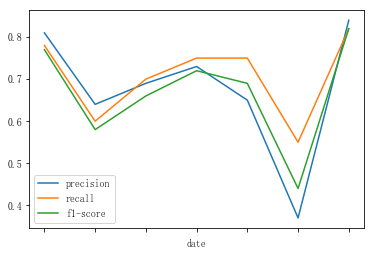

In [42]:
PR_plot_data[PR_plot_data['label'] == 'avg/total'][[ 'date', 'precision', 'recall' ,'f1-score']].plot(x = 'date')
PR_plot_data[PR_plot_data['label'] == 'avg/total']

precision                                            
label         产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                          
20180904     0.940  0.690  0.780 0.940 0.690 0.650 0.690 0.860
20180905     0.000  0.430  0.000 0.940 0.000 0.390 0.610 0.000
20180912     0.000  0.490  0.000 0.970 0.000 0.550 0.780 0.000
20180920     0.000  0.600  0.000 0.970 0.810 0.620 0.000 0.000
20180925     0.000  0.580  0.000 0.000 0.810 0.710 0.710 0.930
20181008     0.000  0.440  0.630 0.000 0.000 0.650 0.590 0.000
20181019     0.870  0.740  0.740 0.940 0.930 0.790 0.630 0.930

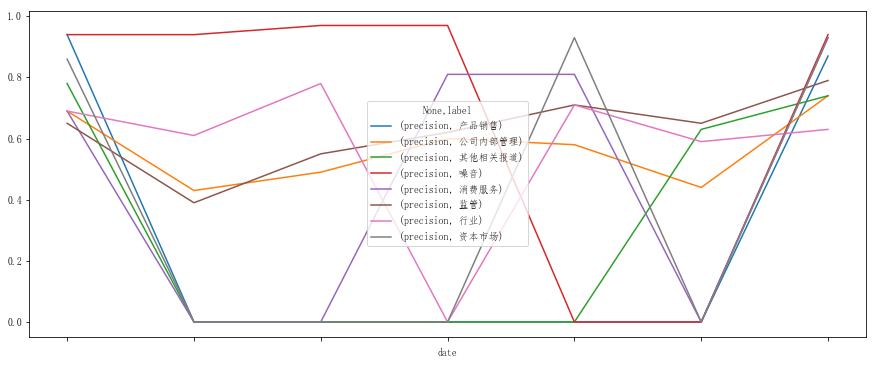

In [43]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'precision']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

recall                                            
label      产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                       
20180904  0.890  0.840  0.920 0.500 0.820 0.980 0.720 0.920
20180905  0.000  0.770  0.000 0.540 0.000 0.940 0.760 0.000
20180912  0.000  0.900  0.000 0.630 0.000 0.980 0.900 0.000
20180920  0.000  0.980  0.000 0.690 0.900 0.880 0.000 0.000
20180925  0.000  0.920  0.000 0.000 0.800 0.930 0.870 0.970
20181008  0.000  0.910  0.750 0.000 0.000 0.980 0.740 0.000
20181019  0.900  0.790  0.800 0.660 0.780 0.960 0.830 0.950

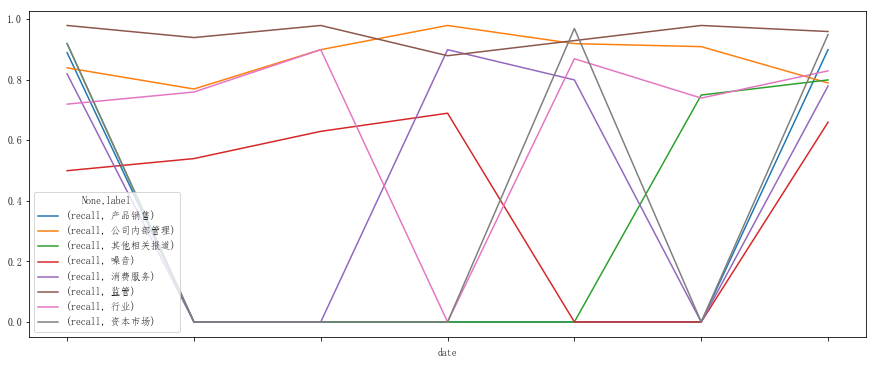

In [44]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'recall']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

f1-score                                            
label        产品销售 公司内部管理 其他相关报道    噪音  消费服务    监管    行业  资本市场
date                                                         
20180904    0.920  0.760  0.840 0.650 0.750 0.780 0.710 0.890
20180905    0.000  0.560  0.000 0.680 0.000 0.550 0.680 0.000
20180912    0.000  0.640  0.000 0.760 0.000 0.700 0.840 0.000
20180920    0.000  0.740  0.000 0.800 0.860 0.730 0.000 0.000
20180925    0.000  0.710  0.000 0.000 0.810 0.800 0.780 0.950
20181008    0.000  0.590  0.690 0.000 0.000 0.780 0.660 0.000
20181019    0.880  0.760  0.770 0.780 0.850 0.870 0.720 0.940

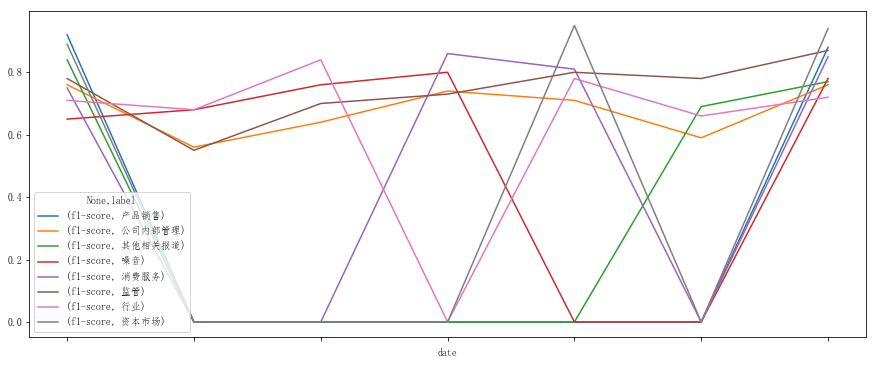

In [45]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'f1-score']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

### 补录与预警数据

In [46]:
file_list_5 = ['20180917_circ_class_feedback.xlsx'
              ] 
add_warn_data = pd.DataFrame()
for file_name in file_list_5:
    currentPath  = '{0}/{1}'.format(folder, file_name)
    excel = xlrd.open_workbook(currentPath)
    sheet_names = [sheet.name for sheet in excel.sheets()]
    for sheet_name in sheet_names:   
        tmp_data = pd.read_excel(currentPath, sheet_name)    
        tmp_data = tmp_data[tmp_data['label'] != '删除']
        add_warn_data = pd.concat([add_warn_data, tmp_data], axis = 0)

circ_raw_class_5 = add_warn_data[['label', 'title', 'content']]

In [47]:
from sklearn import metrics

y_pred_class = add_warn_data['predict_label']
y_test = add_warn_data['label']
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7766599597585513
             precision    recall  f1-score   support

       产品销售       0.36      0.57      0.44         7
     公司内部管理       0.81      0.79      0.80       104
     其他相关报道       0.50      0.50      0.50         2
         噪音       0.20      0.91      0.33        11
       消费服务       0.97      0.48      0.65        62
         监管       0.88      0.81      0.84        72
         行业       0.87      0.88      0.88       211
       资本市场       0.65      0.54      0.59        28

avg / total       0.84      0.78      0.79       497

confusion_matrix: 
[[  4   0   0   0   0   0   3   0]
 [  0  82   0   3   0   2  13   4]
 [  0   0   1   1   0   0   0   0]
 [  0   0   0  10   0   1   0   0]
 [  2   5   1  18  30   0   6   0]
 [  0   0   0  11   0  58   3   0]
 [  5   6   0   5   1   4 186   4]
 [  0   8   0   2   0   1   2  15]]


In [48]:
circ_raw_class_5['label'].value_counts()

行业        211
公司内部管理    104
监管         72
消费服务       62
资本市场       28
噪音         11
产品销售        7
其他相关报道      2
Name: label, dtype: int64

## 合并数据

In [49]:
# file_list_4 = ['20181019_circ_class_feedback.xlsx'] # 多个 sheet
# circ_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_4)
# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [50]:
circ_raw_class = pd.concat([circ_raw_class_1, circ_raw_class_2,
                          circ_raw_class_3, circ_raw_class_4,
                           circ_raw_class_5], 
                         axis = 0)

# circ_raw_class = circ_raw_class_4
circ_raw_class['title_content'] = circ_raw_class['title'].astype(str) + '。' + circ_raw_class['content'].astype(str)
circ_raw_class['label'] = circ_raw_class['label'].apply(lambda x:x.strip())
circ_raw_class['index'] = range(circ_raw_class.shape[0])
print('去重前： ', circ_raw_class.shape)
circ_raw_class = circ_raw_class.drop_duplicates(subset = 'title_content')
print('去重后： ', circ_raw_class.shape)
circ_raw_class.head()

去重前：  (23574, 5)
去重后：  (23559, 5)


,content,label,title,title_content,index
0,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定书之日起60 日内依法向中国保监会申请行政复议，...,公司内部管理,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚。 天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:28\n中国保监会网站\n\r当事人：张磊\n\r身份证号码：32021119690412****\n\r职务：天安佰盈保险销售有限公司宁波分公司（以下简称天安销售宁波分公司）主要负责人\n\r住所：宁波市鄞州区会展路128 号9 层9D04-9D12 室\n\r依据《中华人民共和国保险法》（2015 年修正）的有关规定，我局天安销售宁波分公司涉嫌违法一案进行了调查、审理，依法向当事人告知了作出行政处罚的事实、理由、依据以及当事人依法享有的权利。当事人未陈述申辩，未要求听证。\n\r经查，天安销售宁波分公司存在如下违法行为：\n\r一、财务数据不真实\n\r2016 年，天安销售宁波分公司虚列业务招待费92.33 万元，实际用于向员工发放福利。公司主要负责人张磊为对该行为直接负责的主管人员。\n\r二、变更营业场所地址未按规定报告\n\r2016 年8 月，天安销售宁波分公司营业场所地址由江北区庄桥街道北环西路500 号（5）幢二层5-27 室变更为鄞州区会展路128 号9层9D04-9D12 室。截至2017 年10 月24 日，上述事项未按规定向我局书面报告。公司主要负责人张磊为该机构直接负责的主管人员。\n\r上述事实，有财务凭证、租赁合同、营业执照、情况说明、调查笔录、任职文件、现场检查事实确认书等证据证明。\n\r综上，我局作出如下处罚：\n\r一、天安销售宁波分公司财务数据不真实的行为，违反了《中华人民共和国保险法》（2015 年修正）第八十六条和第一百三十二条的规定。根据《中华人民共和国保险法》（2015 年修正）第一百七十一条的规定，给予张磊警告，并处罚款5 万元的行政处罚。\n\r二、天安销售宁波分公司变更营业场所地址未按规定报告的行为，违反了《保险专业代理机构监管规定》第十四条的规定。根据《保险专业代理机构监管规定》第七十条的规定，给予张磊警告，处罚款1万元的行政处罚。\n\r当事人应当在接到本处罚决定书之日起15 日内持缴款码到财政部指定的12 家代理银行中的任一银行进行同行缴款。逾期，将每日按罚款数额的3%加处罚款（缴款码在行政处罚决定书送达时一并告知）。当事人如对本处罚决定不服，可在接到本处罚决定...,0
1,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减100元”的克扣标准，将该助理原本每月3500元的底薪，克扣到1200元。而这些克扣标准，张龙此前从未告知过刘丽和其他新来的助理。由此，刘丽认为自己遭遇了招聘“骗局”。\n\r 随后，其他新来的助理也知道了薪资标准被故意隐瞒的情况，...,公司内部管理,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元。 泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局” 求职者遭遇违规增员“陷阱”\n\r 早在2009年，原保监会就下发了《关于加强和完善保险营销员管理工作有关事项的通知》，该《通知》中明令禁止现职保险营销人员单独发布招聘信息\n\r 按照 2009年原保监会下发的《关于加强和完善保险营销员管理工作有关事项的通知》 规定，保险公司现职保险营销人员不得单独发布招聘信息，且各公司不得以混淆保险营销人员的职业性质和职位级别等手段误导社会求职人员盲目加入保险营销队伍 ，但在实际操作中，泰康人寿却有大量保险代理人私自以公司的名义发布招聘信息，且以“人力资源专员/助理”等职业称谓混淆营销人员的职业性质。\n\r 记者调查得知，自2017年12月至2018年3月间，泰康人寿长安支公司多位保险代理人相继以泰康人寿北京分公司人事部的名义招聘数名在校大学生，成为长安支公司营销主管张龙(化名)的人力资源助理。期间这些求职者被泰康人寿长安支公司违规收取培训费，并遭到主管张龙隐瞒薪资待遇和克扣应发薪资等不合理对待。\n\r “骗局”?\n\r 据刘丽称，2017年12月初，泰康人寿长安支公司个险营销服务部保险代理人董霞(化名)通过boss直聘网联系大学生刘丽，想要招聘其为支公司人力资源助理。2018年1月4日，刘丽到北京崇文门哈德门广场3楼见到面试官王婷(化名)，经过面试，王婷向刘丽允诺了 “实习期3500元，转正4000元”的薪资待遇。\n\r 4天后，刘丽入职并接受培训，而后成为主管张龙的助理。培训期间，泰康人寿长安支公司通过向建行自动扣款的方式向刘丽收取了100元“岗前培训费”，但刘丽收到的扣款提示信息却显示，该笔款项是以“泰康人寿保险保险费”的名目被扣除的。实际上，按照《关于进一步加强和完善保险营销员管理工作有关事项的通知》规定，保险公司不应向求职者收取培训费用。\n\r 工作期间，刘丽发现张龙在给其助理发放上一个月的薪资时，以“非满勤出席扣500元，未招满4人工资减半，对应招聘差额每人再减1

In [51]:
print(circ_raw_class.shape)
circ_raw_class.groupby('label')['title'].count()

(23559, 5)


label
产品销售      1252
公司内部管理    3030
其他相关报道    2275
噪音        6313
消费服务      2730
监管        2947
行业        3219
资本市场      1793
Name: title, dtype: int64

## 预处理

In [54]:
circ_raw_class.to_excel('circ_result_class/circ_raw_class.xlsx', index = False)

In [53]:
save_folder = 'circ_result_class/'
pre_save(pre_cor_circ.handle_contents, circ_raw_class, save_folder)

(23559, 5)
save_folder:  circ_result_class/
title num:  23559
content num:  23559
天安 销售 虚列费用 员工 发 福利 相关 负责人 被处罚 中国保监会 网站 当事人 张磊 身份证 号码 职务 天安 佰盈 销售 有限公司 宁波 分公司 简称 天安 销售 宁波 分公司 负责人 住所 宁波市 鄞州区 会展 路 号 层 D D 室 中华人民共和国 保险法 年 修正 我局 天安 销售 宁波 分公司 涉嫌 违法 一案 调查 审理 依法 当事人 告知 作出 行政处罚 事实 理由 当事人 依法 享有 权利 当事人 未 陈述 申辩 未 听证 经查 天安 销售 宁波 分公司 违法行为 财务 数据不真实 年 天安 销售 宁波 分公司 虚列 业务 招待费 万元 用于 员工 发放 福利 公司 负责人 张磊 负责 主管人员 变更 营业 场所 地址 未按规定 报告 年 月 天安 销售 宁波 分公司 营业 场所 地址 江北区 庄桥 街道 北环 西路 号 幢 二层 室 变更 鄞州区 会展 路 号 层 D D 室 年 月 日 事项 未按规定 我局 书面报告 公司 负责人 张磊 机构 负责 主管人员 上述事实 财务 凭证 租赁 合同 营业执照 情况 调查 笔录 任职 文件 现场 检查 事实 确认书 证据 证明 综上 我局 作出 处罚 天安 销售 宁波 分公司 财务 数据不真实 违反 中华人民共和国 保险法 年 修正 第八 十六条 第一百 三十二条 中华人民共和国 保险法 年 修正 一百七十 一条 给予 张磊 警告 并处 罚款 万元 行政处罚 天安 销售 宁波 分公司 变更 营业 场所 地址 未按规定 报告 违反 专业 代理 机构 监管 第十四条 专业 代理 机构 监管 七十条 给予 张磊 警告 处 罚款 万元 行政处罚 当事人 接到 处罚 决定书 之日起 日内持 缴款 码到 财政部 指定 家 代理 银行 中 任一 银行 同行 缴款 逾期 每日 罚款 数额 加处 罚款 缴款 码 行政处罚 决定书 送达 时 一并 告知 当事人 如对本 处罚 不服 接到 处罚 决定书 之日起 日内 依法 中国保监会 申请 行政复议 接到 处罚 决定书 之日起 月 内向 管辖权 人民法院 提起 行政诉讼 复议 诉讼 期间 停止 执行 宁波保监局

# 保险业：2 倾向性

## 读取数据

In [ ]:
folder = 'circ_data_tendency/20180905'

### 预测正确数据

In [ ]:
# file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
# circ_raw_class_1 = predict_right(folder, file_list_1)

# circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
# circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
# circ_raw_class_1.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_1.shape)
# circ_raw_class_1.head()

In [ ]:
# circ_raw_class_1['label'].value_counts()

### 预测错误修正后数据

In [ ]:
# file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

# circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
# circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
# circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
# circ_raw_class_2.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_2.shape)
# circ_raw_class_2.head()

In [ ]:
# circ_raw_class_2['label'].value_counts()

### 新补充数据

In [ ]:
file_list_3 = ['circ_0905_neg_raw_data.xlsx', 'circ_0905_pos_raw_data.xlsx',
               'circ_0905_pos_raw_data_add.xlsx'
               ] # 多个 sheet

circ_raw_tendency_3 = get_new_data(folder, file_list_3)

# circ_raw_tendency_3['label'] = circ_raw_tendency_3['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_tendency_3.shape)
circ_raw_tendency_3.head()

In [ ]:
circ_raw_tendency_3['label'].value_counts()

### 模型预测后反馈数据

In [ ]:
# file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180904_circ_class_feedback_1.xlsx',
#               ] # 多个 sheet

# circ_raw_class_4 = get_feedback_data(folder, file_list_4)

# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [ ]:
# circ_raw_class_4['label'].value_counts()

## 合并数据

In [ ]:
# circ_raw_tendency = pd.concat([circ_raw_class_1, circ_raw_class_2,
#                           circ_raw_class_3, circ_raw_class_4], 
#                          axis = 0)

circ_raw_tendency = circ_raw_tendency_3
circ_raw_tendency['title_content'] = circ_raw_tendency['title'].astype(str) + '。' + circ_raw_tendency['content'].astype(str)
# circ_raw_tendency['label'] = circ_raw_tendency['label'].apply(lambda x:x.strip())
# circ_raw_tendency['index'] = range(circ_raw_tendency.shape[0])
print('去重前： ', circ_raw_tendency.shape)
circ_raw_tendency = circ_raw_tendency.drop_duplicates(subset = 'title_content')
print('去重后： ', circ_raw_tendency.shape)
circ_raw_tendency.head()

In [ ]:
print(circ_raw_tendency.shape)
circ_raw_tendency.groupby('label')['title'].count()

## 预处理

In [ ]:
save_folder = 'circ_result_tendency/'
pre_save(pre_cor_circ.handle_contents, circ_raw_tendency, save_folder)

# 保险业：3 预警

- 1: 预警
- 0: 非预警

## 读取数据

In [ ]:
folder = 'circ_data_warn/20180621'

### 预测正确数据

In [ ]:
# file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
# circ_raw_class_1 = predict_right(folder, file_list_1)

# circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
# circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
# circ_raw_class_1.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_1.shape)
# circ_raw_class_1.head()

In [ ]:
# circ_raw_class_1['label'].value_counts()

### 预测错误修正后数据

In [ ]:
# file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

# circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
# circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
# circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
# circ_raw_class_2.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_2.shape)
# circ_raw_class_2.head()

In [ ]:
# circ_raw_class_2['label'].value_counts()

### 新补充数据

In [ ]:
file_list_3 = ['20180621_circ_warn_data.xlsx'
               ] # 多个 sheet

circ_raw_warn_3 = get_new_data(folder, file_list_3)

# circ_raw_warn_3['label'] = circ_raw_warn_3['label'].apply(lambda x:x.strip())    
print('总数：', circ_raw_warn_3.shape)
circ_raw_warn_3.head()

In [ ]:
circ_raw_warn_3['label'].value_counts()

### 模型预测后反馈数据

In [ ]:
# file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180904_circ_class_feedback_1.xlsx',
#               ] # 多个 sheet

# circ_raw_class_4 = get_feedback_data(folder, file_list_4)

# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [ ]:
# circ_raw_class_4['label'].value_counts()

## 合并数据

In [ ]:
# circ_raw_class = pd.concat([circ_raw_class_1, circ_raw_class_2,
#                           circ_raw_class_3, circ_raw_class_4], 
#                          axis = 0)

circ_raw_warn = circ_raw_warn_3
circ_raw_warn['title_content'] = circ_raw_warn['title'].astype(str) + '。' + circ_raw_warn['content'].astype(str)
# circ_raw_warn['label'] = circ_raw_warn['label'].apply(lambda x:x.strip())
circ_raw_warn['index'] = range(circ_raw_warn.shape[0])
print('去重前： ', circ_raw_warn.shape)
circ_raw_warn = circ_raw_warn.drop_duplicates(subset = 'title_content')
print('去重后： ', circ_raw_warn.shape)
circ_raw_warn.head()

In [ ]:
print(circ_raw_warn.shape)
circ_raw_warn.groupby('label')['title'].count()

## 预处理

In [ ]:
save_folder = 'circ_result_warn/'
pre_save(pre_cor_circ.handle_contents, circ_raw_warn, save_folder)

# 银行业：1 八分类

## 读取数据

In [ ]:
folder = 'cbrc_data_class/20180925'

### 预测正确数据

In [ ]:
file_list_1 = ['20180918_cbrc_class_else.xlsx',]
cbrc_raw_class_1 = predict_right(folder, file_list_1)

cbrc_raw_class_1['label'] = cbrc_raw_class_1['label'].apply(lambda x:x.strip())    
cbrc_raw_class_1 = cbrc_raw_class_1[['label', 'raw_title', 'raw_content']]
cbrc_raw_class_1.columns = ['label', 'title', 'content']
print('总数：', cbrc_raw_class_1.shape)
cbrc_raw_class_1.head()

### 预测错误修正后数据

In [ ]:
file_list_2 = ['20180918_cbrc_class_sel.xlsx']

cbrc_raw_class_2 = correct_wrong_data(folder, file_list_2)
cbrc_raw_class_2['label'] = cbrc_raw_class_2['label'].apply(lambda x:x.strip())  
cbrc_raw_class_2 = cbrc_raw_class_2[['备注', 'raw_title', 'raw_content']]
cbrc_raw_class_2.columns = ['label', 'title', 'content']
print('总数：', cbrc_raw_class_2.shape)
cbrc_raw_class_2.head()

### 新补充数据

In [ ]:
# file_list_class_3 = ['20180814_cbrc_class_1.xlsx', '20180814_cbrc_class_2.xlsx',
#                '20180817_cbrc_class_1.xlsx', '20180823_cbrc_class_1.xlsx',
#                '20180823_cbrc_class_2.xlsx', '20180823_cbrc_class_3.xlsx', 
#                '20180824_cbrc_class_1.xlsx', '20180824_cbrc_class_2.xlsx', 
#                '20180824_cbrc_class_3.xlsx', '20180911_cbrc_class_1.xlsx'] # 多个 sheet

# cbrc_raw_class_3 = get_new_data(folder, file_list_class_3)

# cbrc_raw_class_3['label'] = cbrc_raw_class_3['label'].apply(lambda x:x.strip())    
# print('总数：', cbrc_raw_class_3.shape)
# cbrc_raw_class_3.head()

In [ ]:
# cbrc_raw_class_3.groupby('label')['title'].count()

### 模型预测后反馈数据

In [ ]:
file_list_class_4 = ['20181008_cbrc_class_feedback.xlsx','20181030_cbrc_class_feedback.xlsx'
              ] # 多个 sheet

cbrc_raw_class_4, PR_data, PR_plot_data = get_feedback_data(folder, file_list_class_4)

# cbrc_raw_class_4['label'] = cbrc_raw_class_4['label'].apply(lambda x:x.strip())    
print('总数：', cbrc_raw_class_4.shape)
cbrc_raw_class_4.head()

In [ ]:
cbrc_raw_class_4.groupby('label')['title'].count()

#### PR

In [ ]:
y_pred_class = PR_data['predict_label'].tolist()
y_test = PR_data['label'].tolist()
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))
# PR_data.head()

In [ ]:
PR_plot_data[PR_plot_data['label'] == 'avg/total'][[ 'date', 'precision', 'recall' ,'f1-score']].plot(x = 'date')
PR_plot_data[PR_plot_data['label'] == 'avg/total']

In [ ]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'precision']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

In [ ]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'recall']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

In [ ]:
P_data = PR_plot_data[PR_plot_data['label'] != 'avg/total'][ ['date', 'label', 'f1-score']]
P_data.set_index(['date','label']).unstack('label').plot(figsize = (15,6))
P_data.set_index(['date','label']).unstack('label')

## 合并数据

In [ ]:
cbrc_raw_class = pd.concat([cbrc_raw_class_1, cbrc_raw_class_2, cbrc_raw_class_4
                          #cbrc_raw_class_3, 
                        ], 
                         axis = 0)

# cbrc_raw = cbrc_raw_class_4
cbrc_raw_class['title_content'] = cbrc_raw_class['title'].astype(str) + '。' + cbrc_raw_class['content'].astype(str)
cbrc_raw_class['label'] = cbrc_raw_class['label'].apply(lambda x:x.strip())
# cbrc_raw_class['index'] = range(cbrc_raw_class.shape[0])
print('去重前： ', cbrc_raw_class.shape)
cbrc_raw_class = cbrc_raw_class.drop_duplicates(subset = 'title_content')
print('去重后： ', cbrc_raw_class.shape)
cbrc_raw_class.head()

In [ ]:
print(cbrc_raw_class.shape)
cbrc_raw_class.groupby('label')['title'].count()

## 预处理

In [ ]:
cbrc_raw_class.to_excel('circ_result_class/cbrc_raw_class.xlsx')

In [46]:
save_folder = 'cbrc_result_class/'
pre_save(pre_cor_cbrc.handle_contents, cbrc_raw_class, save_folder)

(14192, 4)
save_folder:  cbrc_result_class/
title num:  14192
content num:  14192
月线 反转 阴包 阳 原油 高 先空 美 原油 市场 昨日 月 最终 形态 构造 回顾 月线 走势 月初 行情 低开 位置 行情 先回 补缺 口 给出 新高 行情 压力 回落 周线 黄昏 之星 形态 行情 延续 下行 月 中 行情 最低 位置 行情 整理 最终 月线 收线 月线 行情 一根 下影线 稍 长于 上影线 阴线 形态 收线 形态 收尾 月线 阴包 阳 技术 信号 月线 进一步 回落 低点 需求 点位 今日 给出 轻仓空 止损 目标 上海 原油 操作 今日 给出 空 止损 下方 目标 基本面 刚刚 结束 月 基本面 说 事件 频繁 中 美 开端 欧美 美国 伊朗 制裁 美国 第二季度 GDP 增速 提高 长远 性质 基本面 事件 事件 相关 方都 美国 一步 美国 动向 距离 美国 中期 选举 天 时间 特朗普 想 连任 国内 经济 稳定 竞选 言论 实施 就业 进一步 增强 连任 核心 影响 中美上 美国 亿美元 回补 美国 大豆 种植者 很大 程度 缓解 事件 国内 影响 单边主义 不利于 世界 经济 美国 经济体 美元 国际 唯一 国际 货币 说 主导 全球 经济 发展 方向 美国 损失 世界 国家 补充 美国 中国 政府 富 后果 只能 中国 民众 承担 长此以往 只会 加重 国内 通胀 压力 税负 增加 房地产 泡沫 民众 民企 艰难度日 环境 想要 扩大内需 消耗掉 带来 影响 并非易事 想要 找到 出路 中国政府 需 另辟蹊径 非 一味 对抗 今日 基本面 美国 ADP 就业 数据 数据 非农 前 预期 美国 ISM 制造业 指数 营建 许可 关注 美国 EIA 原油 库存 报告 即可 这一 数据 上周 意外 大跌 本周 数据 关注 明晨 美联储 利率 上限 即可 操作 美 原油 今日 给出 轻仓空 止损 目标 上海 原油 今日 给出 空 止损 下方 目标 阅读 评论 分享 前 一篇 一根 大阳 穿云箭 原油 回 踩 做 发表 评论 新一代 涨粉 神器 
label num:  14192


# 银行业：2 倾向性

## 读取数据

In [50]:
folder = 'cbrc_data_tendency/20180622'

### 预测正确数据

In [51]:
# file_list_1 = ['circ_class_sel_else_20180827.xlsx',]
# circ_raw_class_1 = predict_right(folder, file_list_1)

# circ_raw_class_1['label'] = circ_raw_class_1['label'].apply(lambda x:x.strip())    
# circ_raw_class_1 = circ_raw_class_1[['label', 'raw_title', 'raw_content']]
# circ_raw_class_1.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_1.shape)
# circ_raw_class_1.head()

In [52]:
# circ_raw_class_1['label'].value_counts()

### 预测错误修正后数据

In [53]:
# file_list_2 = ['circ_class_sel_20180827-1.xlsx','circ_class_sel_20180827-2.xlsx']

# circ_raw_class_2 = correct_wrong_data(folder, file_list_2)
# circ_raw_class_2['label'] = circ_raw_class_2['label'].apply(lambda x:x.strip())  
# circ_raw_class_2 = circ_raw_class_2[['备注', 'raw_title', 'raw_content']]
# circ_raw_class_2.columns = ['label', 'title', 'content']
# print('总数：', circ_raw_class_2.shape)
# circ_raw_class_2.head()

In [54]:
# circ_raw_class_2['label'].value_counts()

### 新补充数据

In [55]:
file_list_3 = ['cbrc_0609_pos_raw_data.xlsx', 'cbrc_0609_neg_raw_data.xlsx',
               ] # 多个 sheet

cbrc_raw_tendency_3 = get_new_data(folder, file_list_3)

# circ_raw_tendency_3['label'] = circ_raw_tendency_3['label'].apply(lambda x:x.strip())    
print('总数：', cbrc_raw_tendency_3.shape)
cbrc_raw_tendency_3.head()

Index(['content', 'label', 'title'], dtype='object')
去空值前：  (500, 3) cbrc_0609_pos_raw_data.xlsx Sheet1
去空值后：  (500, 3) cbrc_0609_pos_raw_data.xlsx Sheet1
Index(['content', 'label', 'title'], dtype='object')
去空值前：  (398, 3) cbrc_0609_neg_raw_data.xlsx Sheet1
去空值后：  (398, 3) cbrc_0609_neg_raw_data.xlsx Sheet1
总数： (898, 3)


,label,title,content
0,1,NaN,【消息面解析】 周三(12月14日)原油盘初，油价承压，美油跌逾1%。美油交投于52.3...
1,1,NaN,贵金属各大交易平台:在这两个转换下，总量数据在2010年达到高点后便持续处于下行通道当中，周...
2,1,NaN,关注：掌上有色：隔夜财经数据评论：非农利好提前消化美元持稳 中国数据向好金属表现较好期铜领...
3,1,NaN,周一就被行情怼死，有些意外直接破高，因为要上非农就可以直接涨，但非农冲高回落日线收阴，按理周...
4,1,NaN,今年以来，区环保局围绕区委区政府提出的“干好一三五”总体思路，根据“三年活动”“五大硬仗”总...


In [56]:
cbrc_raw_tendency_3['label'].value_counts()

1    500
0    398
Name: label, dtype: int64

### 模型预测后反馈数据

In [57]:
# file_list_4 = ['20180904_circ_class_feedback.xlsx', '20180904_circ_class_feedback_1.xlsx',
#               ] # 多个 sheet

# circ_raw_class_4 = get_feedback_data(folder, file_list_4)

# circ_raw_class_4['label'] = circ_raw_class_4['label'].apply(lambda x:x.strip())    
# print('总数：', circ_raw_class_4.shape)
# circ_raw_class_4.head()

In [58]:
# circ_raw_class_4['label'].value_counts()

## 合并数据

In [59]:
# circ_raw_tendency = pd.concat([circ_raw_class_1, circ_raw_class_2,
#                           circ_raw_class_3, circ_raw_class_4], 
#                          axis = 0)

cbrc_raw_tendency = cbrc_raw_tendency_3
cbrc_raw_tendency['title_content'] = cbrc_raw_tendency['title'].astype(str) + '。' + cbrc_raw_tendency['content'].astype(str)
# circ_raw_tendency['label'] = circ_raw_tendency['label'].apply(lambda x:x.strip())
# circ_raw_tendency['index'] = range(circ_raw_tendency.shape[0])
print('去重前： ', cbrc_raw_tendency.shape)
cbrc_raw_tendency = cbrc_raw_tendency.drop_duplicates(subset = 'title_content')
print('去重后： ', cbrc_raw_tendency.shape)
cbrc_raw_tendency.head()

去重前：  (898, 4)
去重后：  (896, 4)


,label,title,content,title_content
0,1,NaN,【消息面解析】 周三(12月14日)原油盘初，油价承压，美油跌逾1%。美油交投于52.3...,nan。【消息面解析】 周三(12月14日)原油盘初，油价承压，美油跌逾1%。美油交投于...
1,1,NaN,贵金属各大交易平台:在这两个转换下，总量数据在2010年达到高点后便持续处于下行通道当中，周...,nan。贵金属各大交易平台:在这两个转换下，总量数据在2010年达到高点后便持续处于下行通道...
2,1,NaN,关注：掌上有色：隔夜财经数据评论：非农利好提前消化美元持稳 中国数据向好金属表现较好期铜领...,nan。关注：掌上有色：隔夜财经数据评论：非农利好提前消化美元持稳 中国数据向好金属表现较...
3,1,NaN,周一就被行情怼死，有些意外直接破高，因为要上非农就可以直接涨，但非农冲高回落日线收阴，按理周...,nan。周一就被行情怼死，有些意外直接破高，因为要上非农就可以直接涨，但非农冲高回落日线收阴...
4,1,NaN,今年以来，区环保局围绕区委区政府提出的“干好一三五”总体思路，根据“三年活动”“五大硬仗”总...,nan。今年以来，区环保局围绕区委区政府提出的“干好一三五”总体思路，根据“三年活动”“五大...


In [60]:
print(cbrc_raw_tendency.shape)
cbrc_raw_tendency.groupby('label')['title_content'].count()

(896, 4)


label
0    398
1    498
Name: title_content, dtype: int64

## 预处理

In [61]:
save_folder = 'cbrc_result_tendency/'
pre_save(pre_cor_cbrc.handle_contents, cbrc_raw_tendency, save_folder)

(896, 4)
save_folder:  cbrc_result_tendency/
title num:  896
content num:  896
消息面 解析 周三 月 日 原油 盘初 油价 承压 美油 跌逾 美油 交投 美元 桶 跌幅 约 布油 交投 美元 桶 跌幅 约 OPEC 与非 OPEC 达成 减产 协议 提振 市场 信心 令 油价 近期 高位 国际 能源 署 IEA 最新 公布 月 报 显示 月 全球 原油 供应 创新 高 美国 石油 协会 API 公布 数据 显示 美国 上周 API 原油 库存 汽油 库存 录得 意外 大增 令 油价 承压 日内 公布 OPEC 月 报 美国 EIA 库存 报告 油价 后市 走向 提供 指引 周三 月 日 亚市 盘中 美元 指数 震荡 交投 关口 非美 货币 盘中 涨跌 现货 黄金 盘中 温和 反弹 美国 原油 盘中 小幅 下跌 日 内需 关注 英国 失业率 美国 PPI 零售 销售 工业 产出 EIA 原油 库存 数据 OPEC 公布 月度 原油 市场 报告 英国 央行 行长 卡尼 发表 讲话 北京 时间 周四 凌晨 点将 公布 美联储 决议 技术 面 分析 现货 原油 沥青 周初 冲高回 落后 走 技术 面 调整 收取 带有 一根 影响 阳线 走势 偏 震荡 行情 早间 跳空 低开 配合 预期 技术 面 回调 回 补缺 口 修复 均线 指标 日线图 K 线 回归 于布林 通道 内部 日内 下方 关注 日 均线 支撑 日 均线 高开 缺口 回补 位置 MACD 金叉 运行 红色 动能 缩减 迹象 RSI KDJ 黏合 勾头 向下 发散 指标 呈 弱势 操作 反弹 做空 小时 布 林带 缩口 K 线 运行 中轨 上方 受 均线 压制 下方 短线 关注 中轨 支撑 MACD 死叉 运行 短线 偏 空头 趋势 操作 建议 高 做空 现货 沥青 操作 建议 策略 做空 止损 目标 策略 跌破 反弹 做空 止损 目标 策略 首次 触及 做 止损 目标 策略 由木易 点金 撰稿 分析 以宁贵 沥青 点位 为准 仅供参考 附 国际原油 操作 建议 做空 止损 目标 跌破 反弹 做空 目标 现货 黄金 走势 弱势 修正 想 反弹 日线 均线 压制 力度 一个月 金价 遭遇 上方 均线 压制 呈 弱势 下行 趋势 周一 低

# 保存本文件

In [ ]:
if 0:
    import datetime as dt
    
    def output_HTML(read_file, output_file):
        from nbconvert import HTMLExporter
        import codecs
        import nbformat
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    html_file_folder = 'html_files'
    if not os.path.exists(html_file_folder):
        os.makedirs(html_file_folder)

    today = dt.datetime.now().strftime('%Y%m%d')
    current_file = 'circ_cor_model_2_train.ipynb'
    output_file = 'html_files\%s_%s.html'%(os.path.splitext(current_file)[0], today)
    output_HTML(current_file, output_file)